# Rational
<center>Development for a fitting function (greedy+linear based on mvpolyfit and gmvpfit) that handles rational fucntions</center>

In [2]:
# Low-level import 
from numpy import *
from numpy.linalg import pinv,lstsq
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Setup plotting backend
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import *
#
import positive
from positive import *

## Formalism: An algorithm to model rational functions in the pseudo-linear sense

1. Given $\psi$, and $\vec{x}$, such that 

$$  
\begin{align}
    \psi &= A(\vec{x}) / B(\vec{x}) \text{, where}
    \\
    A(\vec{x}) &= \sum_{j=0}^M ~ a_j \mu^{j}(\vec{x})  
    \\
    B(\vec{x}) &= \sum_{k=0}^N ~ b_k \nu^{k}(\vec{x}) 
    \\ \nonumber
               &= 1 + \sum_{k=1}^{N} ~ b_k \nu^{k}(\vec{x})
\end{align}
$$

2. We care to consider the following to be known and unknown:

 * **Known**: $\psi$, $\vec{x}$, $b_0=1$
 * **Unknown**: $\mu^j$, $\nu^k$
 
3. We seek to write this as a normal linear equation.These manipulations follow:

    $$
    \begin{align}
        &\rightarrow \psi B(\vec{x}) = A(\vec{x})
        \\ \nonumber
        &\rightarrow \psi + \sum_{k=1}^{N} ~ \psi b_k \nu^{k}(\vec{x}) = \sum_{j=0}^M ~ a_j \mu^{j}(\vec{x}) 
        \\ \nonumber
        &\rightarrow \psi = \sum_{j=0}^M ~ a_j \mu^{j}(\vec{x}) - \sum_{k=1}^{N} ~ \psi b_k \nu^{k}(\vec{x})
    \end{align}
    $$

4. We will consider $\psi$ and $\vec{x}$ to be descritized: $\psi_i$ and $\vec{x}_i$, with $0 \le i \le Q$. This gives

    $$
    \begin{align}
        \psi_i = \sum_{j=0}^M ~ a_j \mu^{j}(\vec{x}_i) - \sum_{k=1}^{N} ~ \psi_i b_k \nu^{k}(\vec{x}_i)
    \end{align}
    $$

5. Then, we note that the last line, upon a concatenation of the indeces, may be considered as a matrix operating on a vector. For simplicity we will write this matriv and vector notation.

    $$
    \begin{align}
        \vec{\psi} = \hat{\alpha} \vec{c}
    \end{align}
    $$

    with

    $$
    \begin{align}
        \vec{c} = (c_0,c_1,...c_k,c_k+1,...c_{M+N})
        \\ \nonumber
        c_k = \left\{\begin{array}{ll}
            a_k, & \text{for } 0\leq k \leq M\\
            b_{k-M}, & \text{for } M < k \leq M+N
            \end{array}\right\}
    \end{align}
    $$

    and

    $$
    \begin{align}
        \hat{\alpha} \text{ is of shape } Q \times (M+N+1) \text{, and has elements } \alpha^{k}(\vec{x}_j)
        \\ \nonumber
        \alpha^{k}(\vec{x}_j) = \left\{\begin{array}{ll}
            \mu^k(\vec{x}_j), & \text{for } 0\leq k \leq M\\
            -\psi_j \nu^k(\vec{x}_j), & \text{for } M < k \leq M+N
            \end{array}\right\}
    \end{align}
    $$
    
5. With this, $\vec{c}$ is determined via

    $$
        \vec{c} = \hat{\alpha}^{-1} \vec{\psi}
    $$

## Construction of Test Data

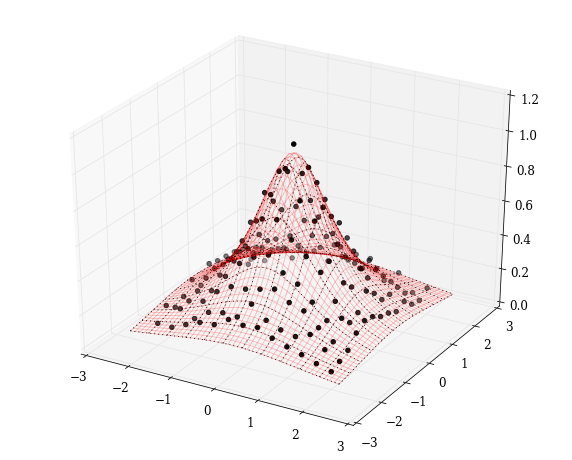

In [2]:
#
h = 2
Q = 13
x = h*linspace(-1,1,Q)
y = h*linspace(-1,1,Q)
X,Y = meshgrid(x,y)
#
zfun = lambda xx,yy: 1.0 / ( 1 + xx**2 + yy**2 )
Z = zfun(X,Y) + 0.1*(np.random.random( X.shape )-0.5)

#
domain,scalar_range = ndflatten( [X,Y], Z )
zfunf = lambda dd: zfun( dd[:,0], dd[:,1] )

#
fig = figure( figsize=2*array([5,4]) )
ax = fig.add_subplot(111,projection='3d')

# Plot the raw data points
ax.scatter( domain[:,0], domain[:,1], scalar_range, marker='o', color='k',zorder=1, facecolors='k')

# Setup grid points for model
padf = 0.1
dx = ( max(domain[:,0])-min(domain[:,0]) ) * padf
dy = ( max(domain[:,1])-min(domain[:,1]) ) * padf
fitx = linspace( min(domain[:,0])-dx, max(domain[:,0])+dx, 45 )
fity = linspace( min(domain[:,1])-dy, max(domain[:,1])+dy, 45 )
xx,yy = meshgrid( fitx, fity )
fitdomain,_ = ndflatten( [xx,yy], yy )
# Plot model on grid

zz = zfunf( fitdomain ).reshape( xx.shape )

#
def testfun( DOMAIN ):
    A = sym_poly_eval( ['K'], [1], DOMAIN )
    B = 1 + sym_poly_eval( ['00','11'], [1,1], DOMAIN )
    ans = A/B
    return ans

zz2 = testfun( fitdomain ).reshape( xx.shape )

ax.plot_wireframe(xx, yy, zz, color='r', rstride=1, cstride=1,zorder=1,alpha=0.25)
ax.plot_wireframe(xx, yy, zz2, linestyle=':', color='k', rstride=4, cstride=4,zorder=1,alpha=1)


## Algorithm Development -- VERSION 0 -- Concept

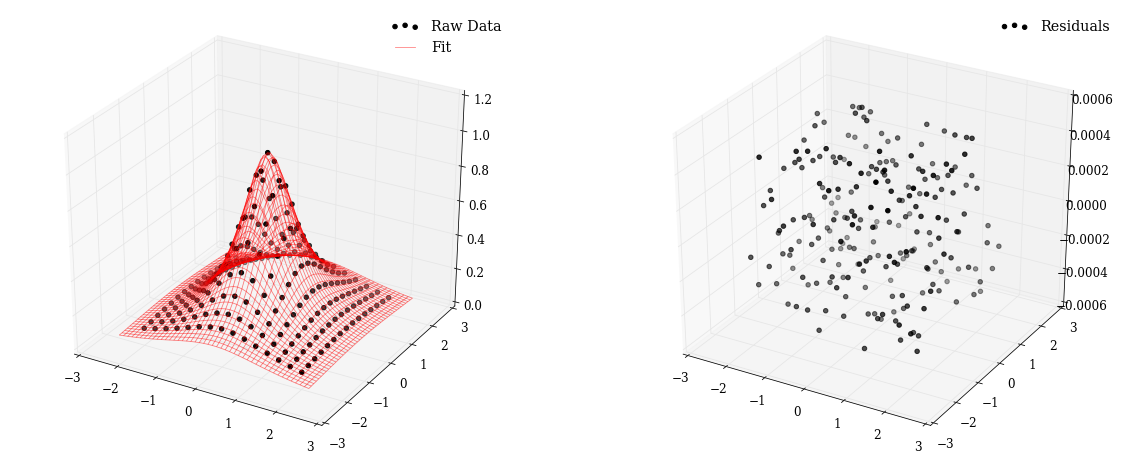

In [42]:
#
h = 2
Q = 15
x = h*linspace(-1,1,Q)
y = h*linspace(-1,1,Q)
X,Y = meshgrid(x,y)
#
zfun = lambda xx,yy: 1.0 / ( 1.0 + 2*xx**2 + yy**2 )
np.random.seed(42)
Z = zfun(X,Y) + 0.001*(np.random.random( X.shape )-0.5)

#
basis_symbols = ( ['K'], ['00','11'] ) # ( [Numerator], [Denominator without constant term] )

#
domain,scalar_range = ndflatten( [X,Y], Z )

# Solver for rational functions in the same form as those for polynomials
def mvrfit( domain, scalar_range, numerator_symbols, denominator_symbols ):
    '''
    '''
    
    #
    from numpy import mean,std

    # Shorthand
    psi = scalar_range
    A_syms = list(numerator_symbols)
    B_syms = list(denominator_symbols)

    #
    M = len( A_syms )
    alpha_kj = array( [ symeval(sym,domain)*( 1 if k < M else -psi) for k,sym in enumerate( A_syms+B_syms ) ] ).T

    # 
    coeffs = lstsq( alpha_kj, psi )[0]

    A_coeffs = coeffs[:M]
    B_coeffs = coeffs[M:]

    #
    def fitfun( DOMAIN ):
        A = sym_poly_eval( A_syms, A_coeffs, DOMAIN )
        B = 1 + sym_poly_eval( B_syms, B_coeffs, DOMAIN )
        ans = A/B
        return ans

    #
    residuals = scalar_range - fitfun( domain )
        
    if max(abs(residuals))<1e-5:
        print max(abs(residuals))
        print coeffs
    
    #
    return A_coeffs, B_coeffs, residuals, fitfun
    

#
# A_coeffs, B_coeffs, residuals, fitfun = mvrfit( domain, scalar_range, basis_symbols[0], basis_symbols[-1] )
    
#
def mvraction( domain,scalar_range, symbols ):
    A_coeffs, B_coeffs, residuals, fitfun = mvrfit( domain, scalar_range, symbols[0], symbols[-1] )
    fit_info = { 'A_coeffs':A_coeffs,
                 'B_coeffs':B_coeffs,
                 'residuals':residuals,
                 'fitfun':fitfun
               }
    return residuals,fit_info
    

# General high-level iterative improvement
def mprove( domain, scalar_range, symbols, action ):
    
    #
    from numpy import mean,std
    
    # Calculate starting residuals
    residuals,fit_info = action(domain, scalar_range, symbols)
    
    # While the solution seems to be changing
    done = False
    last_err = Inf
    iter_max,iter_count = 9,0
    while not done:
        
        # Create the new lhs vector (by subtracting the "noise")
        test_scalar_range = scalar_range - residuals
        
        # Use this to solve for new set of residuals
        residuals,fit_info = action(domain, test_scalar_range, symbols)
        
        #
        print '#%s#\nIteration #%i\n#%s#'%(20*'-~',iter_count,20*'-~')
        print 'mean(residuals) = ',mean(residuals)
        print 'std(residuals) = ',std(residuals)
        err = std(residuals)/abs(max(residuals))
        
        #
        iter_count += 1
        done = iter_count==4 # (iter_count == iter_max) #or (err-last_err)<1e-6
        last_err = err
        print fit_info['A_coeffs'],fit_info['B_coeffs']
        
    #
    return fit_info


################################################################################
# fit_info = mprove( domain, scalar_range, basis_symbols, mvraction )
residuals,fit_info = mvraction(domain, scalar_range, basis_symbols)
# print fit_info['A_coeffs']
# print fit_info['B_coeffs']
################################################################################


#
fig = figure( figsize=2*array([10,4]) )
ax = fig.add_subplot(121,projection='3d')

# Plot the raw data points
ax.scatter( domain[:,0], domain[:,1], scalar_range, marker='o', color='k',zorder=1, facecolors='k',label='Raw Data')

# Setup grid points for model
padf = 0.1
dx = ( max(domain[:,0])-min(domain[:,0]) ) * padf
dy = ( max(domain[:,1])-min(domain[:,1]) ) * padf
fitx = linspace( min(domain[:,0])-dx, max(domain[:,0])+dx, 45 )
fity = linspace( min(domain[:,1])-dy, max(domain[:,1])+dy, 45 )
xx,yy = meshgrid( fitx, fity )
fitdomain,_ = ndflatten( [xx,yy], yy )
# Plot model on grid
zz = fit_info['fitfun']( fitdomain ).reshape( xx.shape )
ax.plot_wireframe(xx, yy, zz, color='r', rstride=1, cstride=1,zorder=1,alpha=0.5,label='Fit')

legend(frameon=False)

ax = fig.add_subplot(122,projection='3d')
ax.scatter( domain[:,0], domain[:,1], fit_info['residuals'].reshape( domain[:,0].shape ), marker='o', color='k',zorder=1, facecolors='k',label='Residuals')
legend(frameon=False)

### NOTES

* It works in the basic sense.
* Centering of the data changes the feature space (i.e. the model's standard form)
* The method appears to be very sensitive to addative noise (likely related to the point above) --> iterative improvement should be considered
* The method above DOES NOT WORK when there is an unknown overall shift to the range; center IS NEEDED

## Algorithm Development -- VERSION 1 -- Add Centering

(mvrfit)>> Centering ON. The input numerator symbols are ['K'], but ['11', 'K', '00'] will be used to accomodate centering.
[-1.14655135  4.58200836 -1.14641012]
[ 0.99763441  0.99833265]


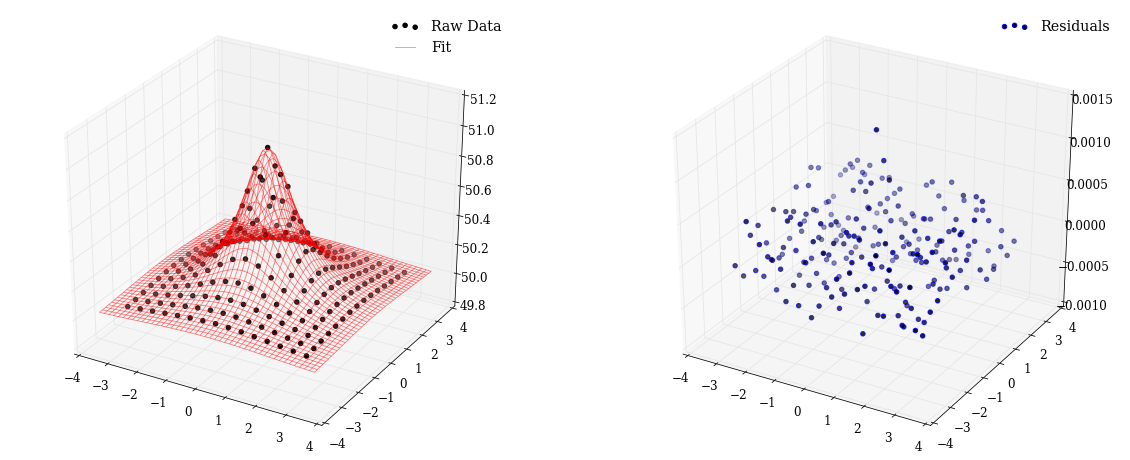

In [16]:
#
h = 3
Q = 15
x = h*linspace(-1,1,Q)
y = h*linspace(-1,1,Q)
X,Y = meshgrid(x,y)
#
zfun = lambda xx,yy: 50 + 1.0 / ( 1.0 + xx**2 + yy**2 )
np.random.seed(42)
Z = zfun(X,Y) + 0.001*(np.random.random( X.shape )-0.5)

#
basis_symbols = ( ['K'], ['00','11'] ) # ( [Numerator], [Denominator without constant term] )

#
domain,scalar_range = ndflatten( [X,Y], Z )

# Solver for rational functions in the same form as those for polynomials
def mvrfit( domain, scalar_range, numerator_symbols, denominator_symbols, centering=True, verbose=True ):
    '''
    '''
    
    #
    from numpy import mean,std

    # Shorthand
    mu = mean(scalar_range)
    sigma = std(scalar_range)
    psi = (scalar_range - mu) / sigma
    B_syms = list(denominator_symbols)
    A_syms = list( set( list(numerator_symbols) + B_syms ) ) if centering else list(numerator_symbols)
    
    #
    if verbose:
        alert('Centering ON. The input numerator symbols are %s, but %s will be used to accomodate centering.'%( yellow(str(numerator_symbols)), yellow(str(A_syms)) ) )

    #
    M = len( A_syms )
    alpha_kj = array( [ symeval(sym,domain)*( 1 if k < M else -psi) for k,sym in enumerate( A_syms+B_syms ) ] ).T

    # 
    coeffs = lstsq( alpha_kj, psi )[0]

    A_coeffs = coeffs[:M]
    B_coeffs = coeffs[M:]

    #
    def fitfun( DOMAIN ):
        A = sym_poly_eval( A_syms, A_coeffs, DOMAIN )
        B = 1 + sym_poly_eval( B_syms, B_coeffs, DOMAIN )
        ans = A/B
        return ans*sigma + mu

    #
    residuals = scalar_range - fitfun( domain )
        
    #
    fit_info = { 'coeffs':coeffs,
                 'A_coeffs':A_coeffs,
                 'B_coeffs':B_coeffs,
                 'residuals':residuals,
                 'fitfun':fitfun
               }
    
    #
    return fit_info


################################################################################
fit_info = mvrfit(domain, scalar_range, basis_symbols[0], basis_symbols[1])
print fit_info['A_coeffs']
print fit_info['B_coeffs']
################################################################################


#
fig = figure( figsize=2*array([10,4]) )
ax = fig.add_subplot(121,projection='3d')

# Plot the raw data points
ax.scatter( domain[:,0], domain[:,1], scalar_range, marker='o', color='k',zorder=1, facecolors='k',label='Raw Data')

# Setup grid points for model
padf = 0.1
dx = ( max(domain[:,0])-min(domain[:,0]) ) * padf
dy = ( max(domain[:,1])-min(domain[:,1]) ) * padf
fitx = linspace( min(domain[:,0])-dx, max(domain[:,0])+dx, 45 )
fity = linspace( min(domain[:,1])-dy, max(domain[:,1])+dy, 45 )
xx,yy = meshgrid( fitx, fity )
fitdomain,_ = ndflatten( [xx,yy], yy )
# Plot model on grid
zz = fit_info['fitfun']( fitdomain ).reshape( xx.shape )
ax.plot_wireframe(xx, yy, zz, color='r', rstride=1, cstride=1,zorder=1,alpha=0.5,label='Fit')

legend(frameon=False)

ax = fig.add_subplot(122,projection='3d')
ax.scatter( domain[:,0], domain[:,1], fit_info['residuals'].reshape( domain[:,0].shape ), marker='o', color='b',zorder=1, facecolors='k',label='Residuals')
legend(frameon=False)

### NOTES

* Centering and some verbose options added.
* The current iteration DOES NOT WORK when there is significant but potentially manageable noise in the data
* Can iterative improvement help with the noise?

## Algorithm Development -- VERSION 2 -- Handle noisey cases

(mvrfit)>> Centering ON. The input numerator symbols are ['K'], but ['11', 'K', '00'] will be used to accomodate centering.
[-0.6113675   2.67949554 -0.6304944 ]
[ 0.46166024  0.43039456]
0.325211422824


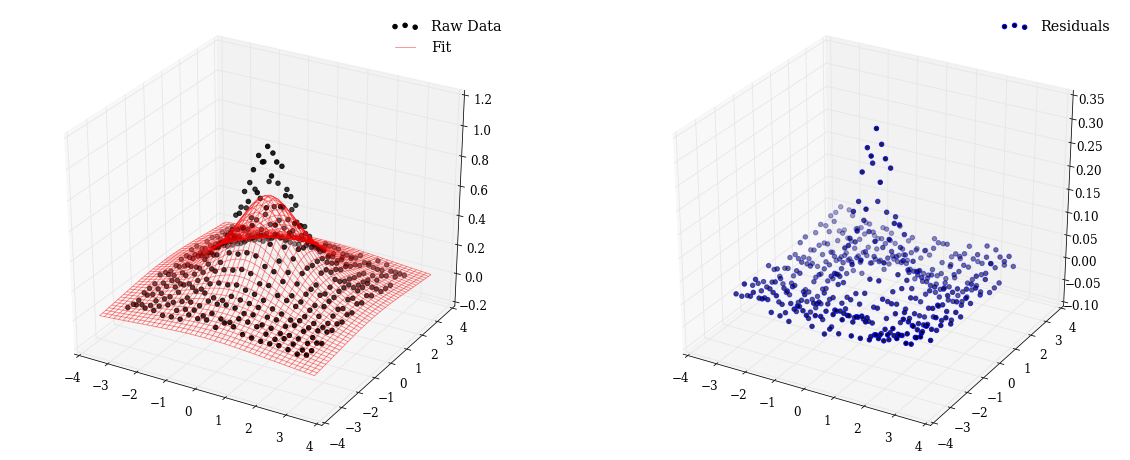

In [35]:
################################################################################
h = 3
Q = 21
x = h*linspace(-1,1,Q)
y = h*linspace(-1,1,Q)
X,Y = meshgrid(x,y)
zfun = lambda xx,yy: 0 + 1.0 / ( 1.0 + xx**2 + yy**2 )
np.random.seed(42)
Z = zfun(X,Y) + 0.05*(np.random.random( X.shape )-0.5)
basis_symbols = ( ['K'], ['00','11'] ) # ( [Numerator], [Denominator without constant term] )
domain,scalar_range = ndflatten( [X,Y], Z )
################################################################################

# Iterative improvement for linear systems of equations
def mprove( A,y, alpha=None, beta=None  ):
    
    '''
    (1) Ideally:        y = A b
    (2) Relaistically:  y+dy = A (b + db)  ** assumption: A is known exactly. This is not really the case for mvrfit.
    
    Incentive: If given db, we can shift our output solution b' = b + db closer to the ideal solution, b = b' - db. This can be done iteratively.
    
    Question: What is db? 
    
    Argument:
    
    (3a)  (1)(2) --> dy = A db
    (3b)  (2) --> dy = A (b + db) - y = residuals
    (4)   (3a)(3b) --> A db = residulas
                   --> db = solver( A,residuals )
                   
    #
    b' = b + db
    b = b' - db 
    '''
    
    #
    from numpy import mean,std
    from numpy.linalg import pinv,lstsq
    
    
    # 
    coeffs = lstsq( A, y )[0]

    #
    calc_res = lambda c: dot(A,c) - y
    residuals = calc_res(coeffs)
        
    #
    done = False
    iter_max = 5
    iter_count = 0
    while not done:
        
        #
        delta = lstsq( A, residuals )[0]
        #delta = dot( pinv(A), residuals )
        
        # Shift the model coefficients
        coeffs -= delta
        
        # Calculate the new residuals
        residuals = calc_res(coeffs)
        
        #
        iter_count += 1
        done = iter_count == iter_max
        
        #
        pad = '--~'*15
        print '#%s#\n%s\n#%s#'%(pad,'# Iteration #%i'%(iter_count),pad)
        print '* mean(residuals) = ',mean(residuals)
        print '*  std(residuals) = ',std(residuals)
        print '> delta  = %s' % delta
        print '> coeffs = %s'% coeffs
        
    #
    return coeffs



# Solver for rational functions in the same form as those for polynomials
def mvrfit( domain, scalar_range, numerator_symbols, denominator_symbols, centering=True, verbose=True ):
    '''
    '''
    
    #
    from numpy import mean,std

    # Shorthand
    mu = mean(scalar_range) if centering else 0
    sigma = std(scalar_range) if centering else 1.0
    psi = (scalar_range - mu) / sigma
    B_syms = list(denominator_symbols)
    A_syms = list( set( list(numerator_symbols) + B_syms ) ) if centering else list(numerator_symbols)
    
    #
    if verbose:
        if centering:
            alert('Centering ON. The input numerator symbols are %s, but %s will be used to accomodate centering.'%( yellow(str(numerator_symbols)), yellow(str(A_syms)) ) )
        else:
            warning('Centering is OFF. This will result in inaccurate results IF the data has a non-zero constant offset.')

    #
    M = len( A_syms )
    alpha = array( [ symeval(sym,domain)*( 1 if k < M else -psi) for k,sym in enumerate( A_syms+B_syms ) ] ).T

    # 
    #coeffs = dot( pinv(alpha), psi )
    #coeffs = lstsq( alpha, psi )[0]
    #coeffs = mprove( alpha, psi )
    
    inv_alpha = pinv(alpha)
    coeffs = dot( inv_alpha, psi )
    #
    kk = 0
    while False: #kk<5:
        residuals = dot( alpha, coeffs ) - psi
        #
        #dcoeffs = dot( inv_alpha, residuals )
        dalpha = array( [ symeval(sym,domain)*( 0 if k < M else -residuals) for k,sym in enumerate( A_syms+B_syms ) ] ).T
        dcoeffs = dot( inv_alpha, residuals ) - dot( inv_alpha, dot(dalpha,coeffs) )
        #
        #print dcoeffs
        coeffs -= dcoeffs
        print '>> ',sum(dcoeffs*dcoeffs)
        kk+=1
        #alpha -= dalpha
        #inv_alpha = pinv(alpha)
        #coeffs = dot( inv_alpha, psi )
    
    A_coeffs = coeffs[:M]
    B_coeffs = coeffs[M:]

    #
    def fitfun( DOMAIN, RAW_COEFFS=None ):
        # Handle optional input of raw fit coefficients
        # NOTE that this option is needed for compatability with iterative improvement
        if RAW_COEFFS is None:
            RAW_COEFFS = coeffs
        # Separate fit coefficitens into those for numerator and denominator
        A_coeffs = RAW_COEFFS[:M]
        B_coeffs = RAW_COEFFS[M:]
        # Evaluate the model
        A = sym_poly_eval( A_syms, A_coeffs, DOMAIN )
        B = 1 + sym_poly_eval( B_syms, B_coeffs, DOMAIN )
        # Shift and scale to preserve mean and sigma of input scalar_range
        ans = (A/B)*sigma + mu
        return ans

    #
    residuals = scalar_range - fitfun( domain )
    
    #
    fit_info = { 'coeffs':coeffs,
                 'A_coeffs':A_coeffs,
                 'B_coeffs':B_coeffs,
                 'residuals':residuals,
                 'fitfun':fitfun
               }
    
    #
    return fit_info
    

    
    
################################################################################
fit_info = mvrfit(domain, scalar_range, basis_symbols[0], basis_symbols[1], centering=not False )
print fit_info['A_coeffs']
print fit_info['B_coeffs']
print max(abs(fit_info['residuals']))
################################################################################


#
fig = figure( figsize=2*array([10,4]) )
ax = fig.add_subplot(121,projection='3d')

# Plot the raw data points
ax.scatter( domain[:,0], domain[:,1], scalar_range, marker='o', color='k',zorder=1, facecolors='k',label='Raw Data')

# Setup grid points for model
padf = 0.1
dx = ( max(domain[:,0])-min(domain[:,0]) ) * padf
dy = ( max(domain[:,1])-min(domain[:,1]) ) * padf
fitx = linspace( min(domain[:,0])-dx, max(domain[:,0])+dx, 45 )
fity = linspace( min(domain[:,1])-dy, max(domain[:,1])+dy, 45 )
xx,yy = meshgrid( fitx, fity )
fitdomain,_ = ndflatten( [xx,yy], yy )
# Plot model on grid
zz = fit_info['fitfun']( fitdomain ).reshape( xx.shape )
ax.plot_wireframe(xx, yy, zz, color='r', rstride=1, cstride=1,zorder=1,alpha=0.5,label='Fit')

legend(frameon=False)

ax = fig.add_subplot(122,projection='3d')
ax.scatter( domain[:,0], domain[:,1], fit_info['residuals'].reshape( domain[:,0].shape ), marker='o', color='b',zorder=1, facecolors='k',label='Residuals')
legend(frameon=False)